# Tutorial 3: Training a Conditional RBM on Artificial Timeseries

In this tutorial/example, we train a Conditional RBM (CRBM) on timeseries data in order to learn to predict the next

##  The Imports
First, we import Tensorflow and numpy packages, as well as the packages we need to visualize the learned filters

In [1]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import sys
sys.path.append('../')

We import the `xrbm.models` module, which contains the `CRBM` model class, as well as the `xrbm.train` module, which contains the `CD-k` approximation algorithm that we use for training our `CRBM`.

In [2]:
import xrbm.models
import xrbm.train
import xrbm.losses
from xrbm.utils.vizutils import *

## Creating the Training Data

To demonestrate using CRBM, we create a simple, 4-dimensional timesries data using sin waves of different frequencies and amplitudes.

In [3]:
NUM_DIM = 4
TIMESTEPS = 3
FREQS = [20, 35, 50, 70]
AMPS = [4, 1, 0.5, 2.5]
NSAMPLE = 100
SEQ_LEN = 2000

time_data = np.arange(SEQ_LEN) / 50

X_train = []

print('Making dummy time series...')
for i in range(NSAMPLE):
    x = [np.float32(
            np.sin(freq * time_data + np.random.rand()/2) *  
            (amp+np.random.rand())) 
         for freq, amp in zip(FREQS, AMPS)]
    
    x = np.asarray(x)
    x = x + np.random.rand(x.shape[0], x.shape[1]) * 1.2
    X_train.append(x.T)

X_train = np.asarray(X_train)

print(X_train.shape)

Making dummy time series...
(100, 2000, 4)


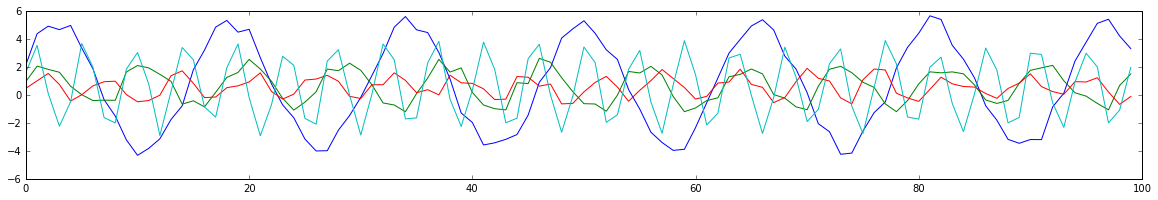

In [4]:
_=plt.figure(figsize=(20,3))
_=plt.plot(X_train[0,0:100,:])

(-6, 6)

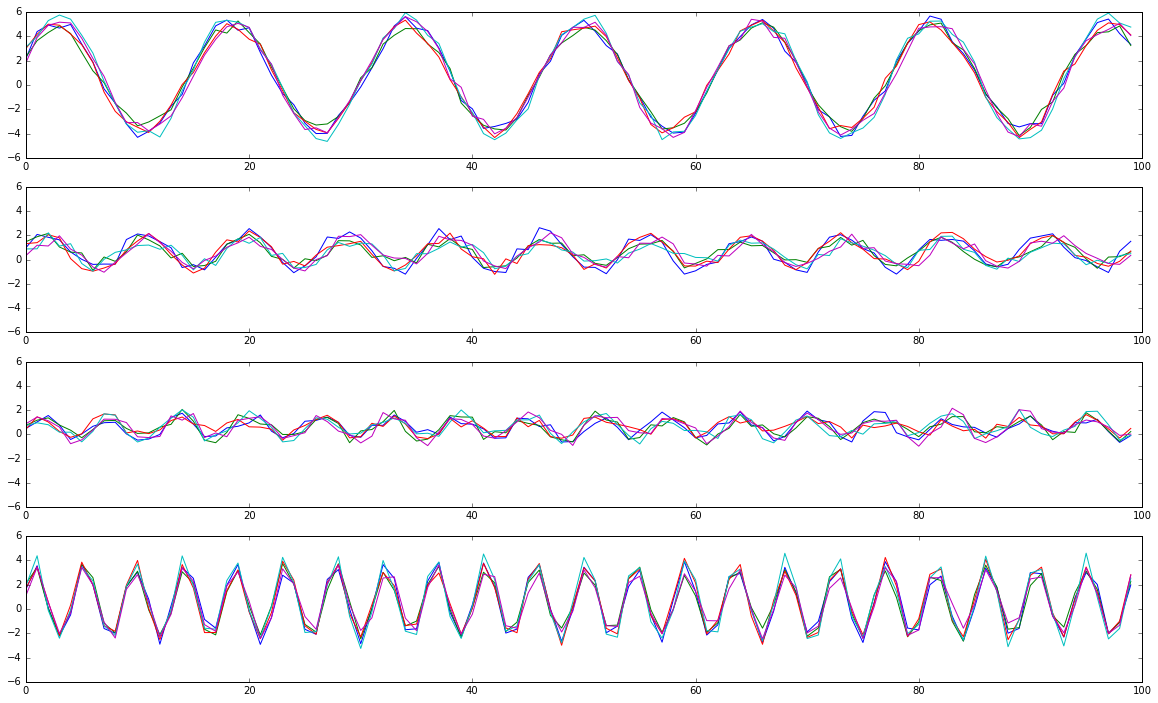

In [5]:
fig=plt.figure(figsize=(20,12))

fig.add_subplot(411)
_=plt.plot(X_train[0:5,0:100,0].T)
plt.ylim(-6, 6)

fig.add_subplot(412)
_=plt.plot(X_train[0:5,0:100,1].T)
plt.ylim(-6, 6)

fig.add_subplot(413)
_=plt.plot(X_train[0:5,0:100,2].T)
plt.ylim(-6, 6)

fig.add_subplot(414)
_=plt.plot(X_train[0:5,0:100,3].T)
plt.ylim(-6, 6)

In [6]:
X_train_flat = np.concatenate([m for m in X_train], axis=0)
data_mean = np.mean(X_train_flat, axis=0)
data_std = np.std(X_train_flat, axis=0)

X_train_normalized = [(d - data_mean) / data_std for d in X_train]

CRBM expects to have condition data, in the form of a `MxN` dimensional matirx. 

So, we put the data into chunks of fixed length

In [7]:
condition_data = []
visible_data = []
for m in X_train_normalized:
    for i in range(len(m)-TIMESTEPS):
        condition_data.append(m[i:i+TIMESTEPS].flatten())
        visible_data.append(m[i+TIMESTEPS])
condition_data = np.asarray(condition_data)
visible_data = np.asarray(visible_data)

## Set Up the Parameters


In [8]:
num_vis         = visible_data.shape[1]
num_cond        = condition_data.shape[1]
num_hid         = 50
learning_rate   = 0.01
batch_size      = 100
training_epochs = 20

### Create an RBM model with the parameters

We create an RBM model, and set the number of visible and hidden units. We can also give it a name. 

In [9]:
# Let's reset the tensorflow graph in case we want to rerun the code
tf.reset_default_graph()

crbm = xrbm.models.CRBM(num_vis=num_vis,
                        num_cond=num_cond,
                        num_hid=num_hid,
                        vis_type='gaussian',
                        #initializer=tf.contrib.layers.xavier_initializer(),
                        name='crbm')

We create the mini-batches:

In [10]:
batch_idxs = np.random.permutation(range(len(visible_data)))
n_batches  = len(batch_idxs) // batch_size

We create a placeholder for the mini-batch data during training.

We use the CD-k algorithm for training the RBM. For this, we create an instance of the `CDApproximator` from the `xrbm.train` module and pass the learning rate to it. 

We then define our training op using the `CDApproximator`'s `train` method, passing the RBM model and the placeholder for the data. 

In order to monitor the training process, we calculate the reconstruction cost of the model at each epoch, using the `rec_cost_op`. 

In [13]:
batch_vis_data     = tf.placeholder(tf.float32, shape=(None, num_vis), name='batch_data')
batch_cond_data    = tf.placeholder(tf.float32, shape=(None, num_cond), name='cond_data')

momentum       = tf.placeholder(tf.float32, shape=())

cdapproximator = xrbm.train.CDApproximator(learning_rate=learning_rate,
                                           momentum=momentum)

train_op       = cdapproximator.train(crbm, vis_data=batch_vis_data, in_data=[batch_cond_data])
reconstructed_data,_,_,_ = crbm.gibbs_sample_vhv(batch_vis_data, [batch_cond_data])
xentropy_rec_cost    = xrbm.losses.cross_entropy(batch_vis_data, reconstructed_data)

### Creatng a generation loop

In [14]:
def generate(c, gen_init_frame = 100, num_gen = 200):
    gen_sample = []
    gen_hidden = []
    initcond = []


    gen_cond = tf.placeholder(tf.float32, shape=[1, num_cond], name='gen_cond_data')
    gen_init = tf.placeholder(tf.float32, shape=[1, num_vis], name='gen_init_data')
    gen_op = c.predict(gen_cond, gen_init, 2)

    for f in range(TIMESTEPS):
        gen_sample.append(np.reshape(visible_data[gen_init_frame+f], [1, num_vis]))

    print('Generating %d frames: '%(num_gen))

    for f in range(num_gen):
        initcond = np.asarray([gen_sample[s] for s in range(f,f+TIMESTEPS)]).ravel()

        initframes = gen_sample[f+TIMESTEPS-1] 
        
        feed = {gen_cond: np.reshape(initcond, [1,num_cond]).astype(np.float32),
                gen_init: initframes }
        
        s, h = sess.run(gen_op, feed_dict=feed)

        gen_sample.append(s)
        gen_hidden.append(h)

    gen_sample = np.reshape(np.asarray(gen_sample), [num_gen+TIMESTEPS,num_vis])

    gen_sample = gen_sample * data_std + data_mean
    
    return gen_sample

Finally, we are ready to run everything and see the results:

Generating 70 frames: 


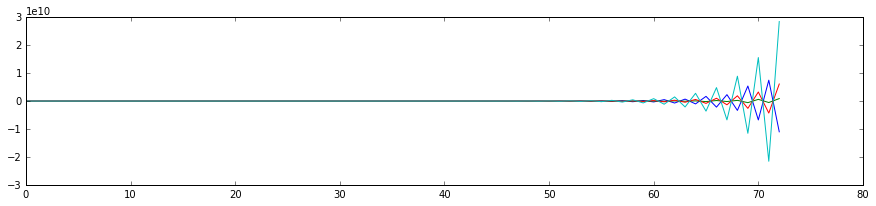

Epoch 1 / 20 | Reconstruction Cost = -3.267640
Epoch 2 / 20 | Reconstruction Cost = -3.213581
Epoch 3 / 20 | Reconstruction Cost = -3.252708
Epoch 4 / 20 | Reconstruction Cost = -3.240213
Epoch 5 / 20 | Reconstruction Cost = -3.223608
Generating 70 frames: 


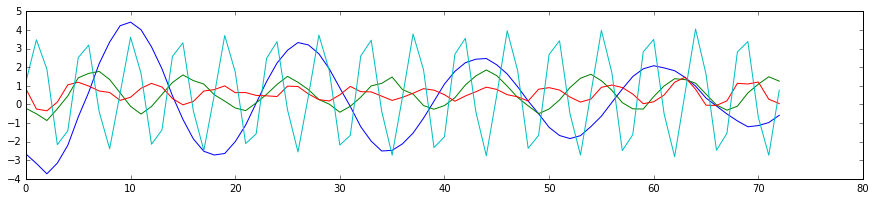

Epoch 6 / 20 | Reconstruction Cost = -3.254361


In [ ]:
with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    

    gen_sample = generate(crbm, num_gen=70)
    fig=fig = plt.figure(figsize=(15, 3))
    _=plt.plot(gen_sample)
    display.display(fig)
            
    for epoch in range(training_epochs):
        
        if epoch < 5: # for the first 5 epochs, we use a momentum coeficient of 0 
            epoch_momentum = 0
        else: # once the training is stablized, we use a momentum coeficient of 0.9
            epoch_momentum = 0.9
        
        
        for batch_i in range(n_batches):
            # Get just minibatch amount of data
            idxs_i = batch_idxs[batch_i * batch_size:(batch_i + 1) * batch_size]
            
            feed = {batch_vis_data: visible_data[idxs_i],
                    batch_cond_data: condition_data[idxs_i],
                    momentum: epoch_momentum}
            
            # Run the training step
            sess.run(train_op, feed_dict=feed)
    
        reconstruction_cost = sess.run(xentropy_rec_cost, feed_dict=feed)


        title = ('Epoch %i / %i | Reconstruction Cost = %f'%
                (epoch+1, training_epochs, reconstruction_cost))
        
        print(title)
        
        if (epoch+1) % 5 == 0:
            gen_sample = generate(crbm, num_gen=70)
            fig = plt.figure(figsize=(15, 3))
            _ = plt.plot(gen_sample)
            display.display(fig)